
## Requirements

Download and install the latest version of catalyst and other libraries required for this tutorial.

In [1]:
import sys
sys.path

['/mnt/963GB/Data/Python/Code/comps/crowdai/gamm_log_facies/catalyst',
 '/home/walle/.virtualenvs/catalyst_base/lib/python37.zip',
 '/home/walle/.virtualenvs/catalyst_base/lib/python3.7',
 '/home/walle/.virtualenvs/catalyst_base/lib/python3.7/lib-dynload',
 '/home/walle/miniconda3/lib/python3.7',
 '',
 '/home/walle/.virtualenvs/catalyst_base/lib/python3.7/site-packages',
 '/home/walle/.virtualenvs/catalyst_base/lib/python3.7/site-packages/IPython/extensions',
 '/home/walle/.ipython']

In [2]:
import os
import random
import collections
from collections import OrderedDict
from typing import Callable, List, Tuple

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
from skimage.io import imread as sk_imread

from sklearn.model_selection import train_test_split

In [3]:
import albumentations as albu
from albumentations.pytorch import ToTensor
import segmentation_models_pytorch as smp
import ttach as tta

In [4]:
import catalyst
from catalyst.dl import utils
from catalyst import utils
from catalyst.contrib.optimizers import RAdam, Lookahead
from catalyst.dl import Callback, CallbackOrder, RunnerState
from catalyst.contrib.criterion import DiceLoss, IoULoss
from catalyst.dl.callbacks import DiceCallback, IouCallback, \
  CriterionCallback, CriterionAggregatorCallback

from catalyst.dl.callbacks import CheckpointCallback
from catalyst.dl import SupervisedRunner

In [5]:
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import optim

In [6]:
import torch

In [7]:
%matplotlib inline 

In [8]:
print(f"torch: {torch.__version__}, catalyst: {catalyst.__version__}")

os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # "" - CPU, "0" - 1 GPU, "0,1" - MultiGPU

SEED = 42
utils.set_global_seed(SEED)
utils.prepare_cudnn(deterministic=True)

torch: 1.3.1, catalyst: 19.12.2


In [9]:
# this variable will be used in `runner.train` and by default we disable FP16 mode
is_fp16_used = True
#with resnext50_32x4d - cant use 275
IMG_SIZE=256

-------

## Dataset

In [10]:
from pathlib import Path

ROOT = Path("../data/segmentation/")

train_image_path = ROOT / "images"
#need 3 channel images
train_mask_path = ROOT / "sc_masks"
test_image_path = ROOT / "test"

In [11]:
train_image_path

PosixPath('../data/segmentation/images')

Collect images and masks into variables.

In [12]:
ALL_IMAGES = sorted(train_image_path.glob("*.png"))
len(ALL_IMAGES)

28000

In [13]:
ALL_MASKS = sorted(train_mask_path.glob("*.png"))
len(ALL_MASKS)

28000

In [14]:
def show_examples(name: str, image: np.ndarray, mask: np.ndarray):
    plt.figure(figsize=(10, 14))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Image: {name}")

    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title(f"Mask: {name}")


def show(index: int, images: List[Path], masks: List[Path], transforms=None) -> None:
    image_path = images[index]
    name = image_path.name

    image = utils.imread(image_path)
    mask = sk_imread(masks[index])

    if transforms is not None:
        temp = transforms(image=image, mask=mask)
        image = temp["image"]
        mask = temp["mask"]

    show_examples(name, image, mask)

def show_random(images: List[Path], masks: List[Path], transforms=None) -> None:
    length = len(images)
    index = random.randint(0, length - 1)
    show(index, images, masks, transforms)

You can restart the cell below to see more examples.

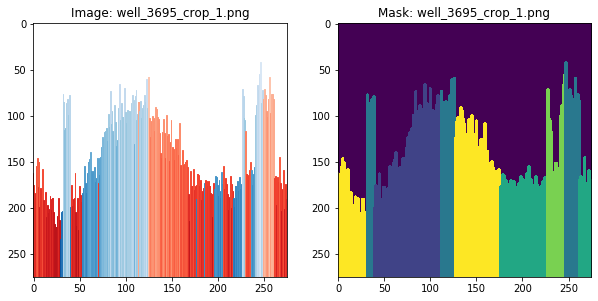

In [15]:
show_random(ALL_IMAGES, ALL_MASKS)

The dataset below reads images and masks and optionally applies augmentation to them.

In [16]:
class SegmentationDataset(Dataset):
    def __init__(
        self,
        images: List[Path],
        masks: List[Path] = None,
        transforms=None
    ) -> None:
        self.images = images
        self.masks = masks
        self.transforms = transforms

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> dict:
        image_path = self.images[idx]
        image = utils.imread(image_path)
        
        result = {"image": image}
        
        if self.masks is not None:
            mask = sk_imread(self.masks[idx])
            print(f'raw mask: {mask}')
            mask=mask.astype(np.int64)
            print(f'int mask: {mask}')
            result["mask"] = mask
            
        
        if self.transforms is not None:
            result = self.transforms(**result)
        
        result["filename"] = image_path.name
        return result

-------

### Augmentations

[![Albumentation logo](https://albumentations.readthedocs.io/en/latest/_static/logo.png)](https://github.com/albu/albumentations)

The [albumentation](https://github.com/albu/albumentations) library works with images and masks at the same time, which is what we need.

In [17]:
def pre_transforms(image_size=IMG_SIZE):
    return [albu.Resize(image_size, image_size, p=1)]


def hard_transforms():
    result = [
      albu.Cutout(num_holes=5, max_h_size=20, max_w_size=20, fill_value=255,p=0.25),
    ]

    return result
  

def resize_transforms(image_size=IMG_SIZE):
    BORDER_CONSTANT = 0
    pre_size = int(image_size * 1.5)

    random_crop = albu.Compose([
      albu.SmallestMaxSize(pre_size, p=1),
      albu.RandomCrop(
          image_size, image_size, p=1
      )

    ])

    rescale = albu.Compose([albu.Resize(image_size, image_size, p=1)])

    random_crop_big = albu.Compose([
      albu.LongestMaxSize(pre_size, p=1),
      albu.RandomCrop(
          image_size, image_size, p=1
      )

    ])

    # Converts the image to a square of size image_size x image_size
    result = [
      albu.OneOf([
          random_crop,
          rescale,
          random_crop_big
      ], p=1)
    ]

    return result
  
def post_transforms():
    # we use ImageNet image normalization
    # and convert it to torch.Tensor
    return [albu.Normalize(), ToTensor()]
  
def compose(transforms_to_compose):
    # combine all augmentations into one single pipeline
    result = albu.Compose([
      item for sublist in transforms_to_compose for item in sublist
    ])
    return result

NB need to use post_transforms - is moves the third axis to first (or adds a first if 2d) 
- which is format required by catalyst ie ch, r, c

In [18]:
train_transforms = compose([
    #resize_transforms(), 
    pre_transforms(),
    hard_transforms(), 
    post_transforms()
])
valid_transforms = compose([pre_transforms(), post_transforms()])

show_transforms = compose([hard_transforms()])

Let's look at the augmented results. <br/>
You can restart the cell below to see more examples of augmentations.

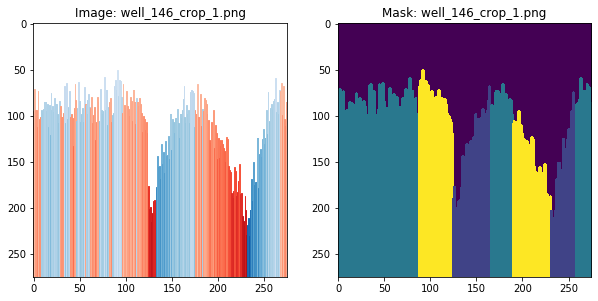

In [19]:
show_random(ALL_IMAGES, ALL_MASKS, transforms=show_transforms)

-------

## Loaders

In [20]:
def get_loaders(
    images: List[Path],
    masks: List[Path],
    random_state: int,
    valid_size: float = 0.2,
    batch_size: int = 32,
    num_workers: int = 4,
    train_transforms_fn = None,
    valid_transforms_fn = None,
) -> dict:

    indices = np.arange(len(images))

    # Let's divide the data set into train and valid parts.
    train_indices, valid_indices = train_test_split(
      indices, test_size=valid_size, random_state=random_state, shuffle=True
    )

    np_images = np.array(images)
    np_masks = np.array(masks)

    # Creates our train dataset
    train_dataset = SegmentationDataset(
      images = np_images[train_indices].tolist(),
      masks = np_masks[train_indices].tolist(),
      transforms = train_transforms_fn
    )

    # Creates our valid dataset
    valid_dataset = SegmentationDataset(
      images = np_images[valid_indices].tolist(),
      masks = np_masks[valid_indices].tolist(),
      transforms = valid_transforms_fn
    )

    # Catalyst uses normal torch.data.DataLoader
    train_loader = DataLoader(
      train_dataset,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      drop_last=True,
    )

    valid_loader = DataLoader(
      valid_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      drop_last=True,
    )

    # And excpect to get an OrderedDict of loaders
    loaders = collections.OrderedDict()
    loaders["train"] = train_loader
    loaders["valid"] = valid_loader

    return loaders

In [21]:
if is_fp16_used:
    batch_size = 64
else:
    batch_size = 32

print(f"batch_size: {batch_size}")

loaders = get_loaders(
    images=ALL_IMAGES,
    masks=ALL_MASKS,
    random_state=SEED,
    train_transforms_fn=train_transforms,
    valid_transforms_fn=valid_transforms,
    batch_size=batch_size
)

batch_size: 64


-------

## Experiment
### Model

Catalyst has [several segmentation models](https://github.com/catalyst-team/catalyst/blob/master/catalyst/contrib/models/segmentation/__init__.py#L16) (Unet, Linknet, FPN, PSPnet and their versions with pretrain from Resnet).

> You can read more about them in [our blog post](https://github.com/catalyst-team/catalyst-info#catalyst-info-1-segmentation-models).

But for now let's take the model from [segmentation_models.pytorch](https://github.com/qubvel/segmentation_models.pytorch) (SMP for short). The same segmentation architectures have been implemented in this repository, but there are many more pre-trained encoders.

[![Segmentation Models logo](https://raw.githubusercontent.com/qubvel/segmentation_models.pytorch/master/pics/logo-small-w300.png)](https://github.com/qubvel/segmentation_models.pytorch)

In [22]:
aux_params=dict(
    dropout=0.5,               # dropout ratio, default is None
    classes=6,                 # define number of output labels
)

# We will use Feature Pyramid Network with pre-trained ResNeXt50 backbone
model = smp.FPN(encoder_name="resnext50_32x4d", classes=6, aux_params=aux_params)

### Model training

We will optimize loss as the sum of IoU, Dice and BCE, specifically this function: $IoU + Dice + 0.8*BCE$.


In [23]:
# we have multiple criterions
criterion = {
    "dice": DiceLoss(),
    "iou": IoULoss(),
    #"bce": nn.BCEWithLogitsLoss()
    "ce": nn.CrossEntropyLoss()
}

In [24]:
learning_rate = 0.001
encoder_learning_rate = 0.0005

# Since we use a pre-trained encoder, we will reduce the learning rate on it.
layerwise_params = {"encoder*": dict(lr=encoder_learning_rate, weight_decay=0.00003)}

# This function removes weight_decay for biases and applies our layerwise_params
model_params = utils.process_model_params(model, layerwise_params=layerwise_params)

# Catalyst has new SOTA optimizers out of box
base_optimizer = RAdam(model_params, lr=learning_rate, weight_decay=0.0003)
optimizer = Lookahead(base_optimizer)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.25, patience=2)

In [25]:
num_epochs = 3
logdir = "./logs/segmentation"

device = utils.get_device()
print(f"device: {device}")

if is_fp16_used:
    fp16_params = dict(opt_level="O1") # params for FP16
else:
    fp16_params = None

print(f"FP16 params: {fp16_params}")


# by default SupervisedRunner uses "features" and "targets",
# in our case we get "image" and "mask" keys in dataset __getitem__
runner = SupervisedRunner(device=device, input_key="image", input_target_key="mask")

device: cuda
FP16 params: {'opt_level': 'O1'}


### Monitoring in tensorboard

If you do not have a Tensorboard opened after you have run the cell below, try running the cell again.

In [26]:
%load_ext tensorboard
%tensorboard --logdir {logdir}

Reusing TensorBoard on port 6007 (pid 3435), started 8:37:13 ago. (Use '!kill 3435' to kill it.)

### Running train-loop

In [27]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    
    # our dataloaders
    loaders=loaders,
    
    callbacks=[
        # Each criterion is calculated separately.
        CriterionCallback(
            input_key="mask",
            prefix="loss_dice",
            criterion_key="dice"
        ),
        CriterionCallback(
            input_key="mask",
            prefix="loss_iou",
            criterion_key="iou"
        ),
        CriterionCallback(
            input_key="mask",
            prefix="loss_ce",
            criterion_key="ce"
        ),
        
        # And only then we aggregate everything into one loss.
        CriterionAggregatorCallback(
            prefix="loss",
            loss_aggregate_fn="weighted_sum", # can be "sum", "weighted_sum" or "mean"
            # because we want weighted sum, we need to add scale for each loss
            loss_keys={"loss_dice": 0.5, "loss_iou": 0.5, "loss_bce": 1.0},
        ),
        
        # metrics
        DiceCallback(input_key="mask"),
        IouCallback(input_key="mask"),
    ],
    # path to save logs
    logdir=logdir,
    
    num_epochs=num_epochs,
    
    # save our best checkpoint by CE metric
    main_metric="ce",
    # CE needs to be minimised.
    minimize_metric=True,
    
    # for FP16. It uses the variable from the very first cell
    fp16=fp16_params,
    
    # prints train logs
    verbose=True,
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
1/3 * Epoch (train):   0% 0/350 [00:00<?, ?it/s]>>_process_input_str batch: torch.Size([64, 3, 256, 256])
--_compute_loss() output: torch.Size([64, 6, 256, 256]) torch.float32, input: torch.Size([64, 1, 256, 256]) torch.float32
--_compute_loss() output: torch.Size([64, 6, 256, 256]) torch.float32, input: torch.S

RuntimeError: Expected object of scalar type Long but got scalar type Float for argument #2 'target' in call to _thnn_nll_loss2d_forward

### Training analysis

The `utils.plot_metrics` method reads tensorboard logs from the logdir and plots beautiful metrics with `plotly` package.

In [ ]:
# tensorboard should be enought, uncomment to check plotly version
# it can take a while (colab issue)
# utils.plot_metrics(
#     logdir=logdir, 
#     # specify which metrics we want to plot
#     metrics=["loss", "accuracy01", "auc/_mean", "f1_score", "_base/lr"]
# )

## Model inference

Let's look at model predictions.


In [21]:
TEST_IMAGES = sorted(test_image_path.glob("*.png"))

# create test dataset
test_dataset = SegmentationDataset(
    TEST_IMAGES, 
    transforms=valid_transforms
)

num_workers: int = 4

infer_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers
)

# this get predictions for the whole loader
predictions = runner.predict_loader(
    model=model,
    loader=infer_loader,
    resume=f"{logdir}/checkpoints/best.pth",
    verbose=False,
)

print(type(predictions))
print(predictions.shape)

=> loading checkpoint ./logs/segmentation/checkpoints/best.pth
loaded checkpoint ./logs/segmentation/checkpoints/best.pth (epoch 3)
Top best models:

<class 'numpy.ndarray'>
(100064, 1, 224, 224)


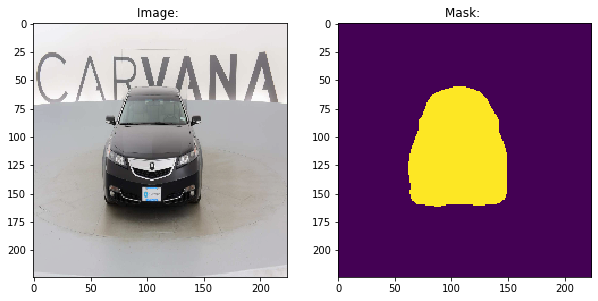

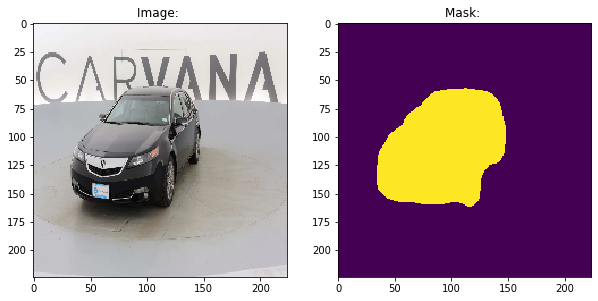

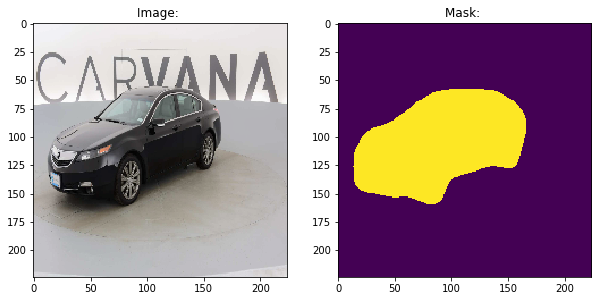

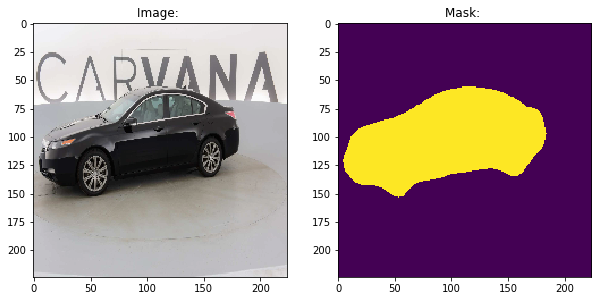

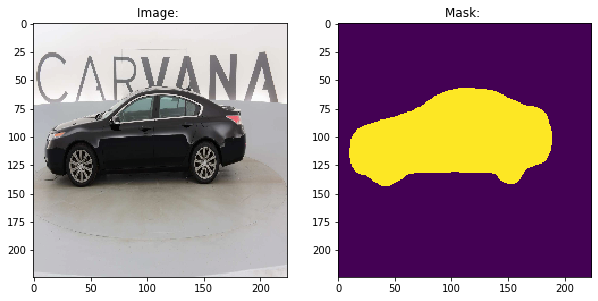

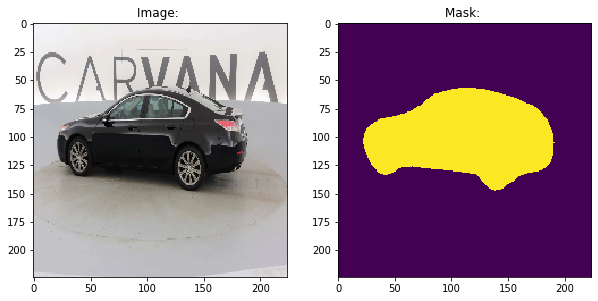

In [22]:
threshold = 0.5
max_count = 5

for i, (features, logits) in enumerate(zip(test_dataset, predictions)):
    image = utils.tensor_to_ndimage(features["image"])

    mask_ = torch.from_numpy(logits[0]).sigmoid()
    mask = utils.detach(mask_ > threshold).astype("float")
        
    show_examples(name="", image=image, mask=mask)
    
    if i >= max_count:
        break

## Model tracing

Catalyst allows you to use Runner to make [tracing](https://pytorch.org/docs/stable/jit.html) models.

> How to do this in the Config API, we wrote in [our blog (issue \#2)](https://github.com/catalyst-team/catalyst-info#catalyst-info-2-tracing-with-torchjit)

For this purpose it is necessary to pass in a method `trace ` model and a batch on which `predict_batch ` will be executed:

In [ ]:
batch = next(iter(loaders["valid"]))
# saves to `logdir` and returns a `ScriptModule` class
runner.trace(model=model, batch=batch, logdir=logdir, fp16=is_fp16_used)

!ls {logdir}/trace/

After this, you can easily load the model and predict anything!

In [ ]:
if is_fp16_used:
    model = utils.load_traced_model(f"{logdir}/trace/traced-forward-opt_O1.pth", device="cuda", opt_level="O1")
else:
    model = utils.load_traced_model(f"{logdir}/trace/traced-forward.pth", device="cpu")

In [ ]:
model_input = batch["image"].to("cuda" if is_fp16_used else "cpu")
model(model_input)

### Advanced: Custom Callbacks

Let's plot the heatmap of predicted masks.

In [ ]:
class CustomInferCallback(Callback):
    def __init__(self):
        super().__init__(CallbackOrder.Internal)
        self.heatmap = None
        self.counter = 0

    def on_loader_start(self, state: RunnerState):
        self.predictions = None
        self.counter = 0

    def on_batch_end(self, state: RunnerState):
        # data from the Dataloader
        # image, mask = state.input["image"], state.input["mask"]
        logits = state.output["logits"]
        probabilities = torch.sigmoid(logits)

        self.heatmap = (
            probabilities 
            if self.heatmap is None 
            else self.heatmap + probabilities
        )
        self.counter += len(probabilities)

    def on_loader_end(self, state: RunnerState):
        self.heatmap = self.heatmap.sum(axis=0)
        self.heatmap /= self.counter

In [ ]:
infer_loaders = {"infer": loaders["valid"]}
model = smp.FPN(encoder_name="resnext50_32x4d", classes=6, dropout=0.05)

device = utils.get_device()
if is_fp16_used:
    fp16_params = dict(opt_level="O1") # params for FP16
else:
    fp16_params = None

runner = SupervisedRunner(device=device, input_key="image", input_target_key="mask")
runner.infer(
    model=model,
    loaders=infer_loaders,
    callbacks=OrderedDict([
        ("loader", CheckpointCallback(resume=f"{logdir}/checkpoints/best.pth")),
        ("infer", CustomInferCallback())
    ]),
    fp16=fp16_params,
)

In [ ]:


heatmap = utils.detach(runner.callbacks["infer"].heatmap[0])
plt.figure(figsize=(20, 9))
plt.imshow(heatmap, cmap="hot", interpolation="nearest")
plt.show()

### Advanced: test-time augmentations (TTA)

There is [ttach](https://github.com/qubvel/ttach) is a new awesome library for test-time augmentation for segmentation or classification tasks.

In [ ]:


# D4 makes horizontal and vertical flips + rotations for [0, 90, 180, 270] angels.
# and then merges the result masks with merge_mode="mean"
tta_model = tta.SegmentationTTAWrapper(model, tta.aliases.d4_transform(), merge_mode="mean")

tta_runner = SupervisedRunner(
    model=tta_model,
    device=utils.get_device(),
    input_key="image"
)

In [ ]:
infer_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=num_workers
)

batch = next(iter(infer_loader))

# predict_batch will automatically move the batch to the Runner's device
tta_predictions = tta_runner.predict_batch(batch)

# shape is `batch_size x channels x height x width`
print(tta_predictions["logits"].shape)

Let's see our mask after TTA

In [ ]:
threshold = 0.5

image = utils.tensor_to_ndimage(batch["image"][0])

mask_ = tta_predictions["logits"][0, 0].sigmoid()
mask = utils.detach(mask_ > threshold).astype("float")

show_examples(name="", image=image, mask=mask)